# Import Library

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid') 

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import PowerTransformer,PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder , LabelEncoder ,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Get Data

In [2]:
Diamond=pd.read_csv('/kaggle/input/diamonds-prices/Diamonds Prices2022.csv')
Diamond

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53939,53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64
53940,53941,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49
53941,53942,0.71,Premium,F,SI1,59.8,62.0,2756,5.74,5.73,3.43


In [3]:
Diamond.drop(columns = "Unnamed: 0",inplace = True)

In [4]:
Diamond.shape

(53943, 10)

# Tack a Quick look at Data

In [5]:
Diamond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   price    53943 non-null  int64  
 7   x        53943 non-null  float64
 8   y        53943 non-null  float64
 9   z        53943 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
Diamond.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

* There aren't missing data  

In [7]:
Diamond.duplicated().sum()

149

* There are 146 duplicated rows  

In [8]:
Diamond.describe()

,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


* Min value of "x", "y", "z" are zero this indicates that there are faulty values in data that represents dimensionless or 2-dimensional diamonds. So we need to filter out those as it clearly faulty data points.


In [9]:
Diamond.shape

(53943, 10)

In [10]:
Diamond.describe(include = "O")

,cut,color,clarity
count,53943,53943,53943
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13067


array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

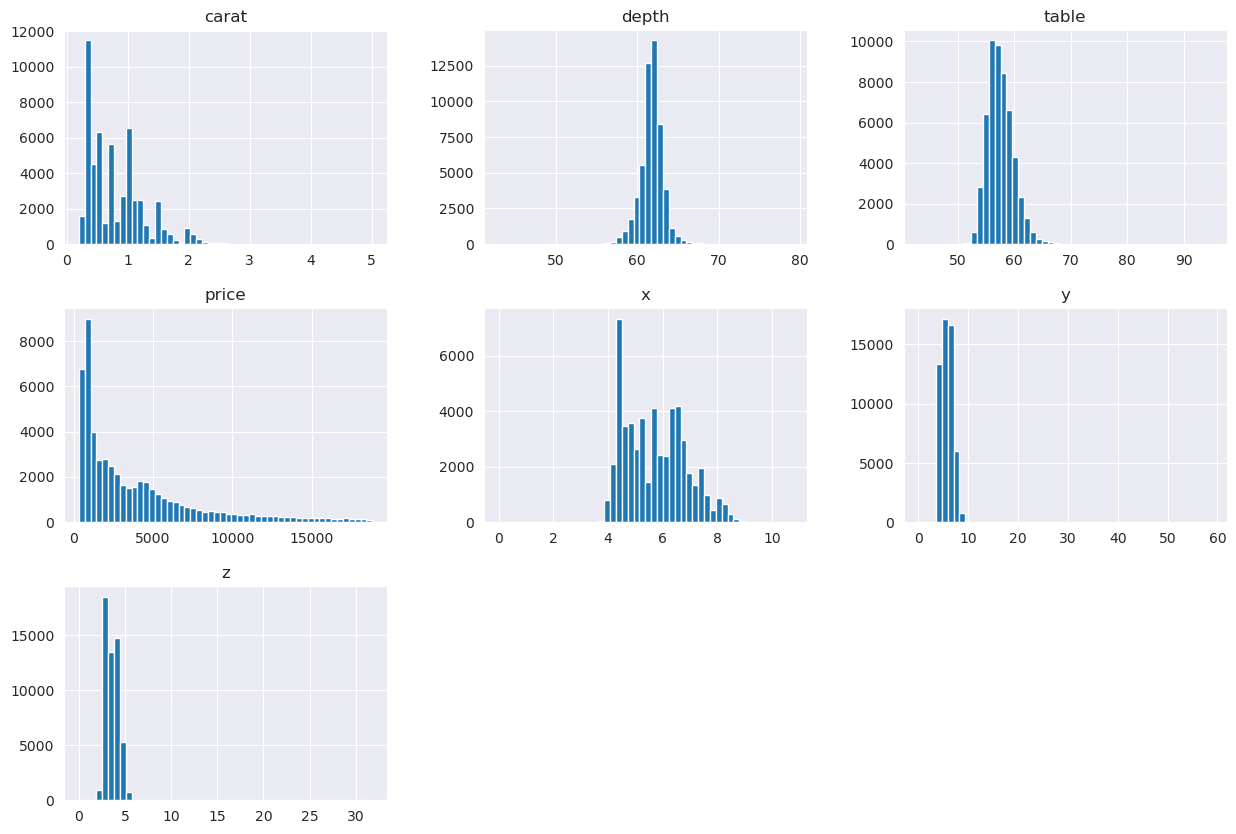

In [11]:
Diamond.hist(bins = 50 , figsize = (15,10))

**Points to notice :**

 * Target column (price) is skewed right
 * Depth column and tabel column are capped
 * Also y and z column are capped 
 
   * So, we need to manipulate with this 

# Create Test Set 

In [12]:
diamond_copy = Diamond.copy()
diamond_copy.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [13]:
diamond_train , diamond_test = train_test_split(diamond_copy , test_size = 0.2 , random_state = 120 )
display(diamond_train.shape)
display(diamond_test.shape)

(43154, 10)

(10789, 10)

# Discover Data & Gain Insights

In [14]:
diamond_train['Price'] = diamond_train['price']
diamond_train.drop(columns =['price'],inplace = True)

In [15]:
diamond_train

,carat,cut,color,clarity,depth,table,x,y,z,Price
39054,0.38,Very Good,F,VS1,62.1,54.7,4.63,4.66,2.89,1058
7435,0.90,Fair,F,VS2,64.4,53.0,6.08,6.04,3.90,4229
43118,0.52,Ideal,D,SI2,62.5,56.0,5.12,5.08,3.19,1385
7394,0.33,Premium,H,VS1,59.5,59.0,4.48,4.53,2.68,579
39313,0.38,Ideal,H,VVS2,61.4,57.0,4.65,4.63,2.85,1069
...,...,...,...,...,...,...,...,...,...,...
11646,1.20,Premium,J,VS2,62.6,57.0,6.80,6.72,4.23,5053
33503,0.30,Ideal,F,VS2,60.5,56.0,4.37,4.33,2.63,828
17566,1.20,Ideal,H,VS2,61.2,59.0,6.84,6.89,4.20,7072
42752,0.58,Ideal,G,SI2,62.2,55.0,5.40,5.36,3.35,1343


In [16]:
diamond_train['Price']

39054    1058
7435     4229
43118    1385
7394      579
39313    1069
         ... 
11646    5053
33503     828
17566    7072
42752    1343
32423     791
Name: Price, Length: 43154, dtype: int64

In [17]:
diamond_train[['Price']]

,Price
39054,1058
7435,4229
43118,1385
7394,579
39313,1069
...,...
11646,5053
33503,828
17566,7072
42752,1343


<AxesSubplot:xlabel='Price', ylabel='Count'>

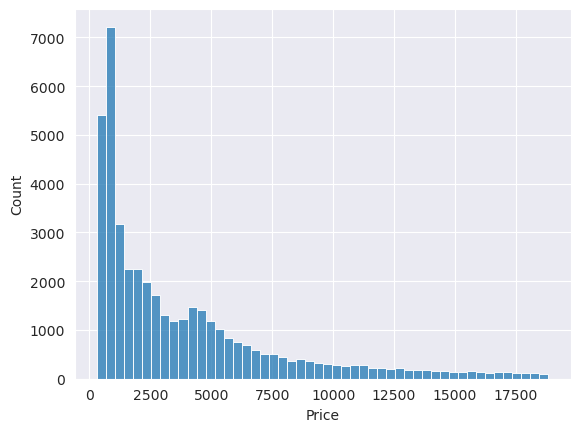

In [18]:
#Target Column 
sns.histplot(x = "Price" , data = diamond_train, bins = 50)

<AxesSubplot:xlabel='Price', ylabel='Count'>

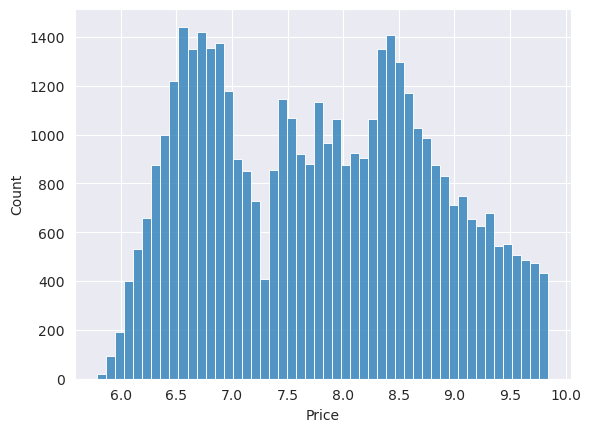

In [19]:
diamond_train['Price'] =np.log1p(diamond_train['Price'])
sns.histplot(x = "Price" , data = diamond_train, bins = 50)

In [20]:
powerTrans = PowerTransformer()

diamond_train['Price'] =powerTrans.fit_transform(diamond_train[['Price']])

## 1- Univariate Analysis

<AxesSubplot:ylabel='carat'>

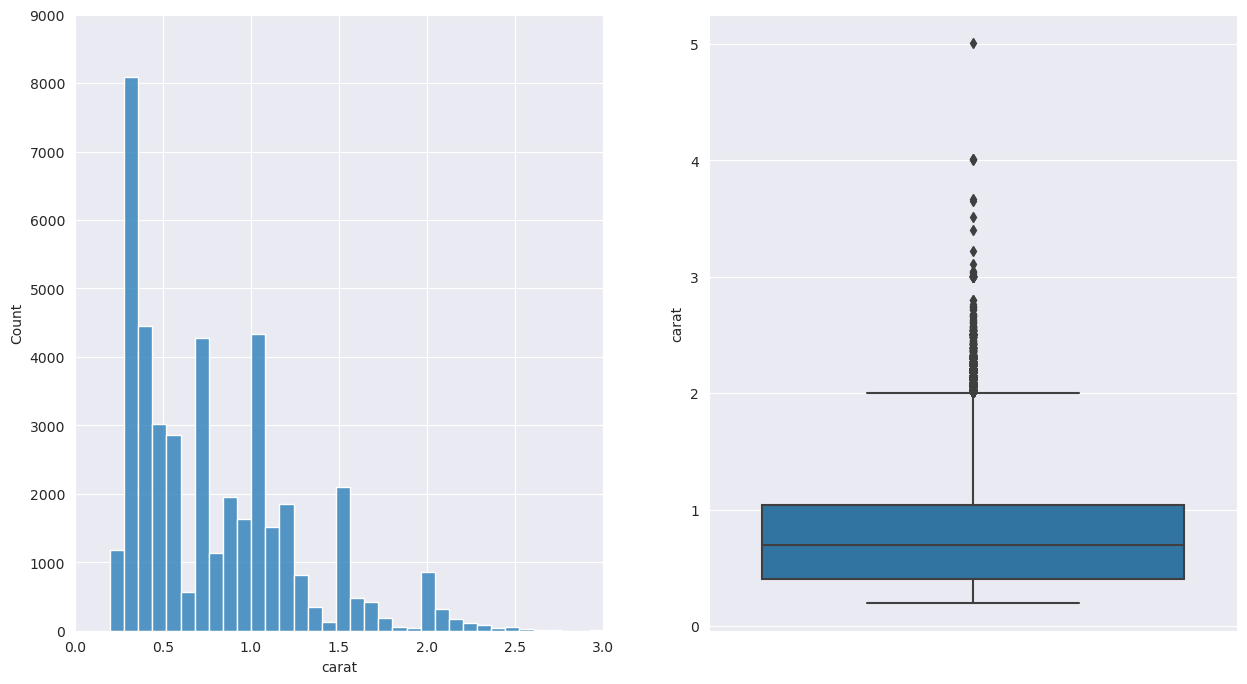

In [21]:
# carat column
plt.figure(figsize = (15,8))
plt.subplot(121)
plt.axis([0,3,0,9000])
sns.histplot(x = "carat" , data = diamond_train, bins = 60)
plt.subplot(122)
sns.boxplot(y = "carat" , data = diamond_train)


In [22]:
diamond_train["carat"].value_counts()

0.30    2074
0.31    1812
1.01    1787
0.70    1584
0.32    1441
        ... 
4.00       1
3.22       1
3.67       1
2.67       1
2.71       1
Name: carat, Length: 268, dtype: int64

<AxesSubplot:ylabel='x'>

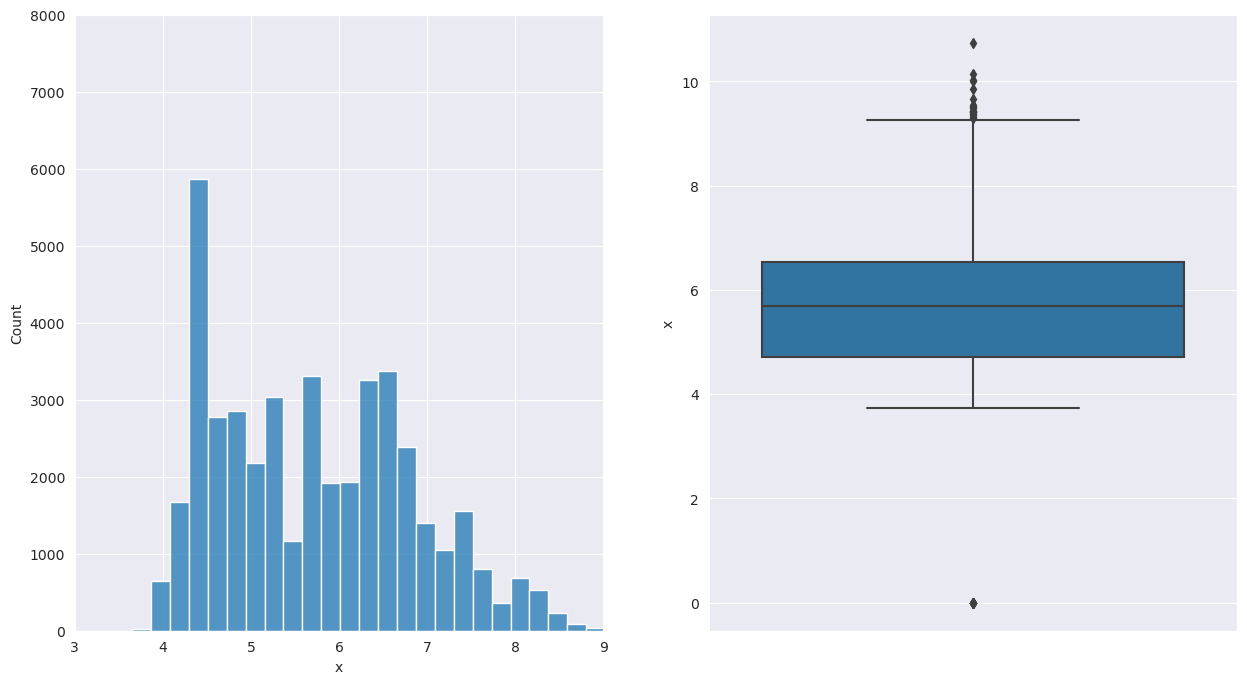

In [23]:
# x column
plt.figure(figsize = (15,8))
plt.subplot(121)
plt.axis([3,9,0,8000])
sns.histplot(x = "x" , data = diamond_train, bins = 50)
plt.subplot(122)
sns.boxplot(y = "x" , data = diamond_train)

<AxesSubplot:ylabel='y'>

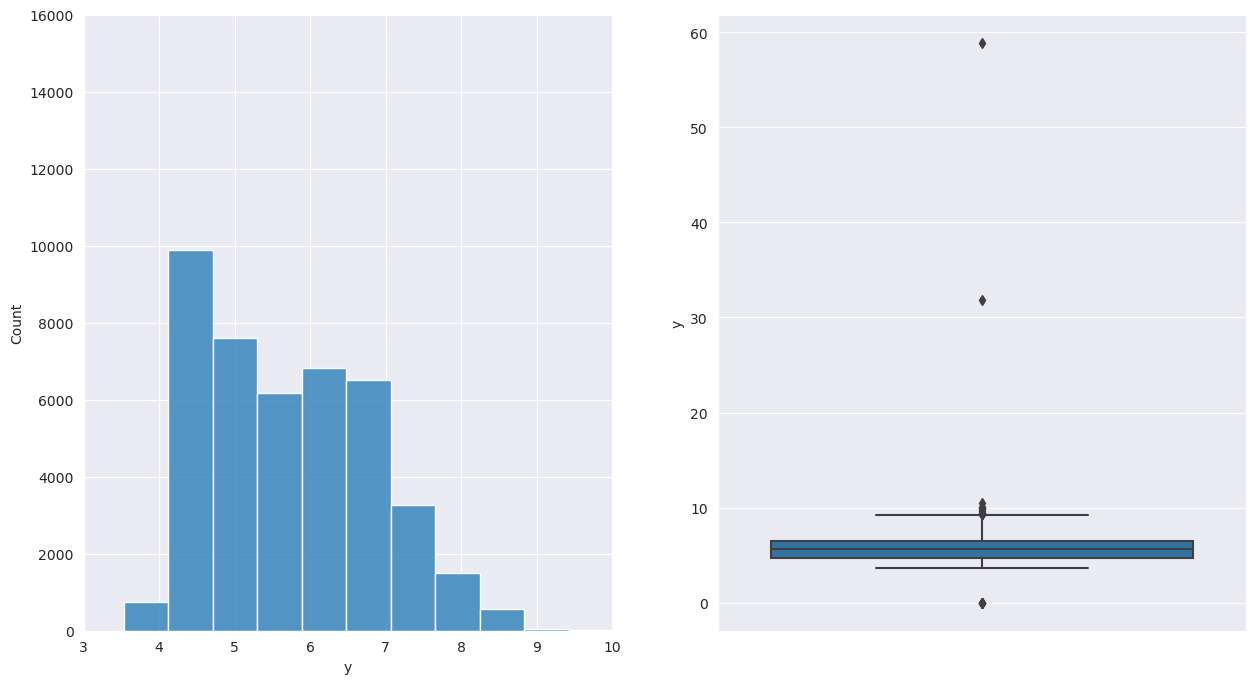

In [24]:
plt.figure(figsize = (15,8))
plt.subplot(121)
plt.axis([3,10,0,16000])
sns.histplot(x = "y" , data = diamond_train, bins = 100)
plt.subplot(122)
sns.boxplot(y= "y" , data = diamond_train)


<AxesSubplot:ylabel='z'>

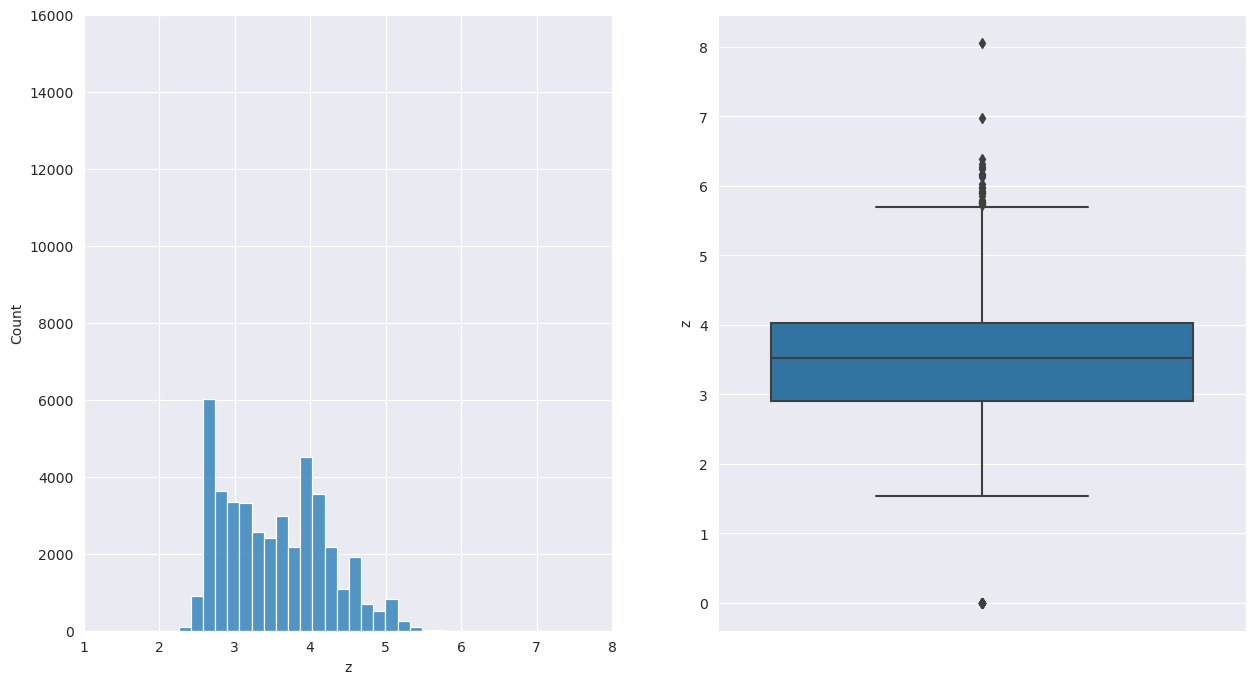

In [25]:
plt.figure(figsize = (15,8))
plt.subplot(121)
plt.axis([1,8,0,16000])
sns.histplot(x = "z" , data = diamond_train, bins = 50)
plt.subplot(122)
sns.boxplot(y = "z" , data = diamond_train)

* From figures above, it,s clrearly there are some Outlier.

<AxesSubplot:xlabel='cut', ylabel='count'>

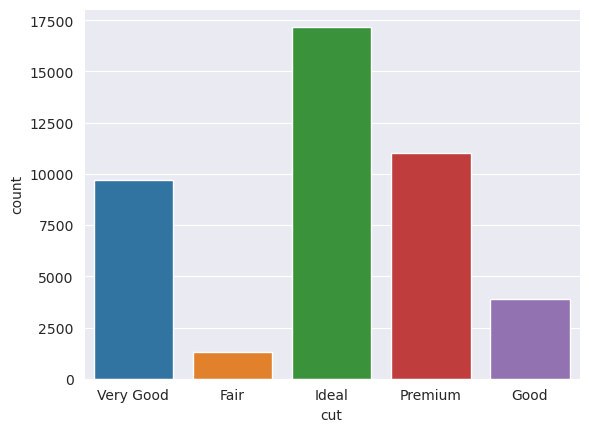

In [26]:
sns.countplot(x = "cut", data = diamond_train)

<AxesSubplot:xlabel='color', ylabel='count'>

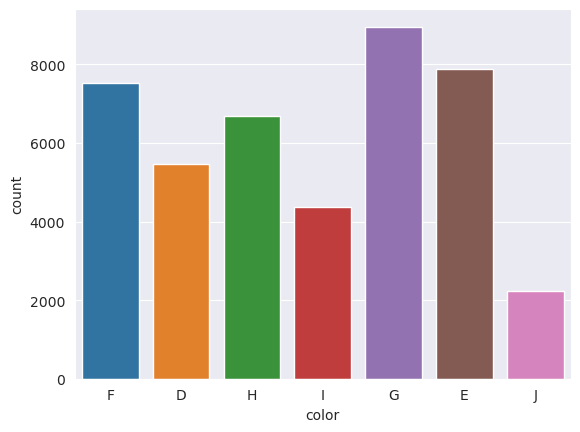

In [27]:
sns.countplot(x = "color", data = diamond_train)

<AxesSubplot:xlabel='clarity', ylabel='count'>

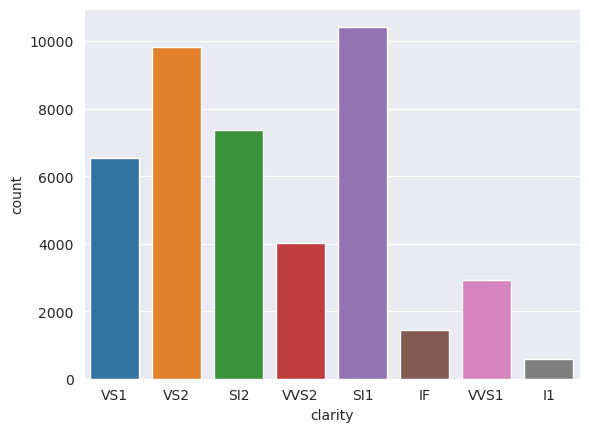

In [28]:
sns.countplot(x = "clarity", data = diamond_train)

## 2- Bivariate Analysis


### 2.1- Looking for Correlations

In [29]:
corr_matrix = diamond_train.corr()
corr_matrix["Price"].sort_values(ascending = False)

Price    1.000000
x        0.953615
z        0.945579
y        0.926296
carat    0.909514
table    0.158110
depth    0.003450
Name: Price, dtype: float64

<AxesSubplot:>

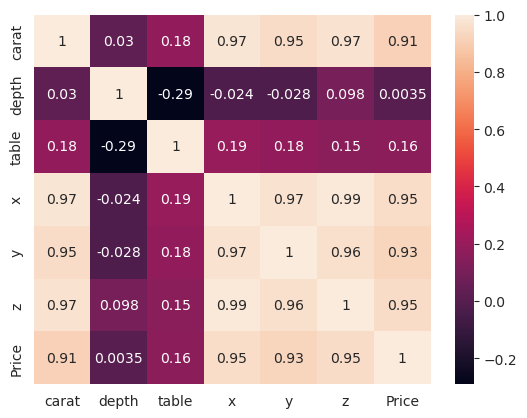

In [30]:
sns.heatmap(corr_matrix , annot = True)

* There is a strong Correlation between x,y,z,carat and Price.

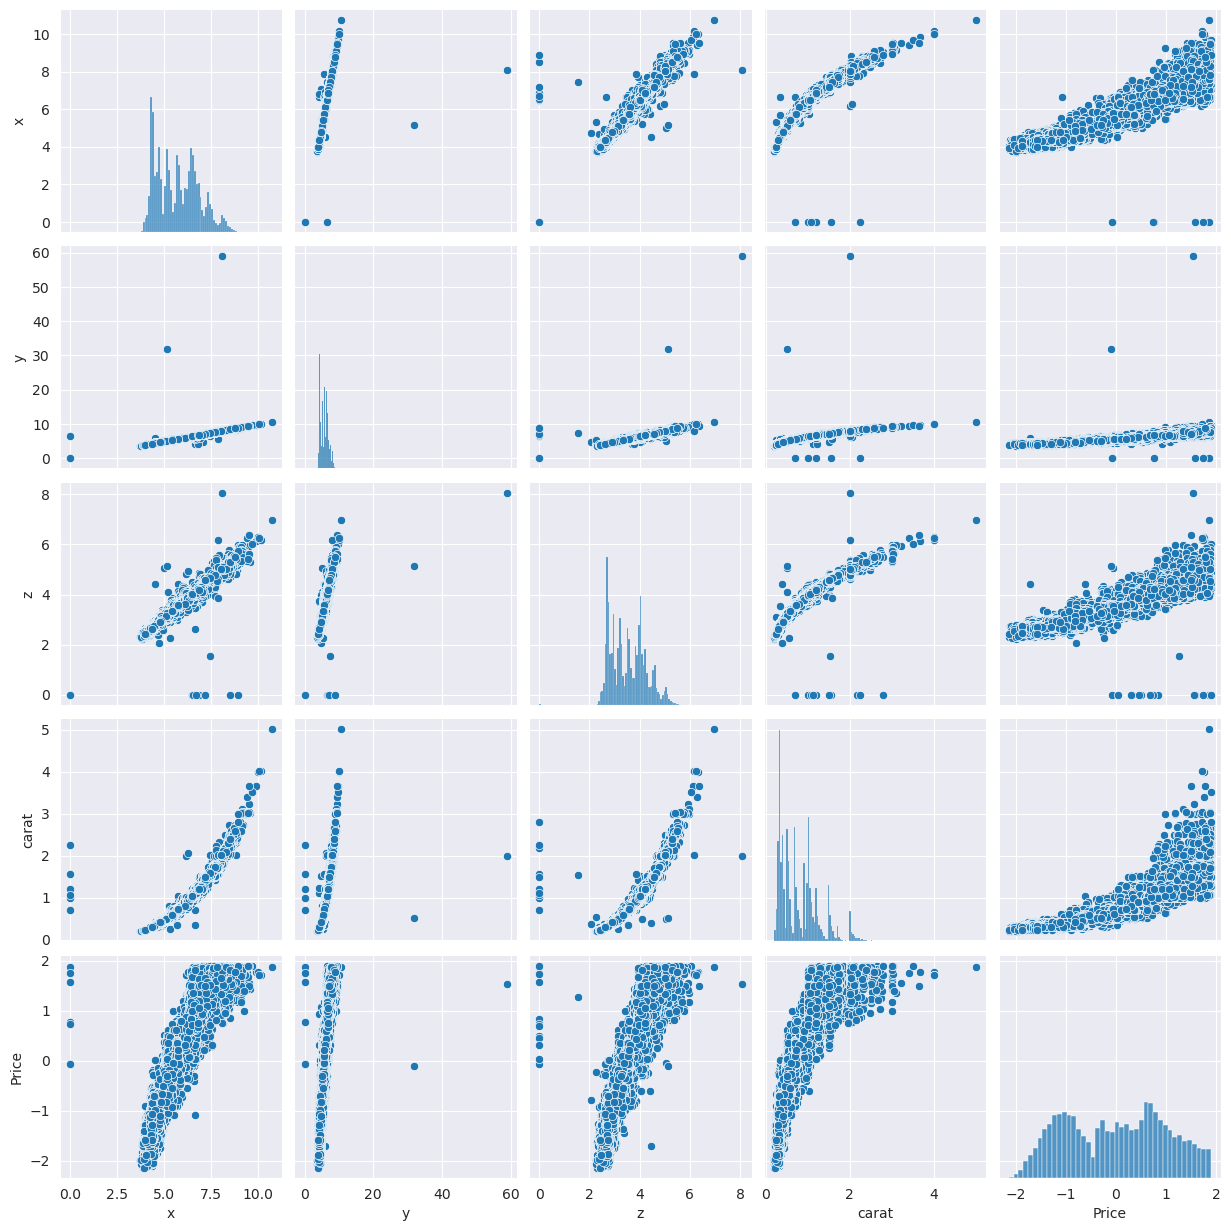

In [31]:
attr =["x","y","z","carat","Price"]
sns.pairplot(diamond_train[attr])

### **Clearly, there are some Outliers**

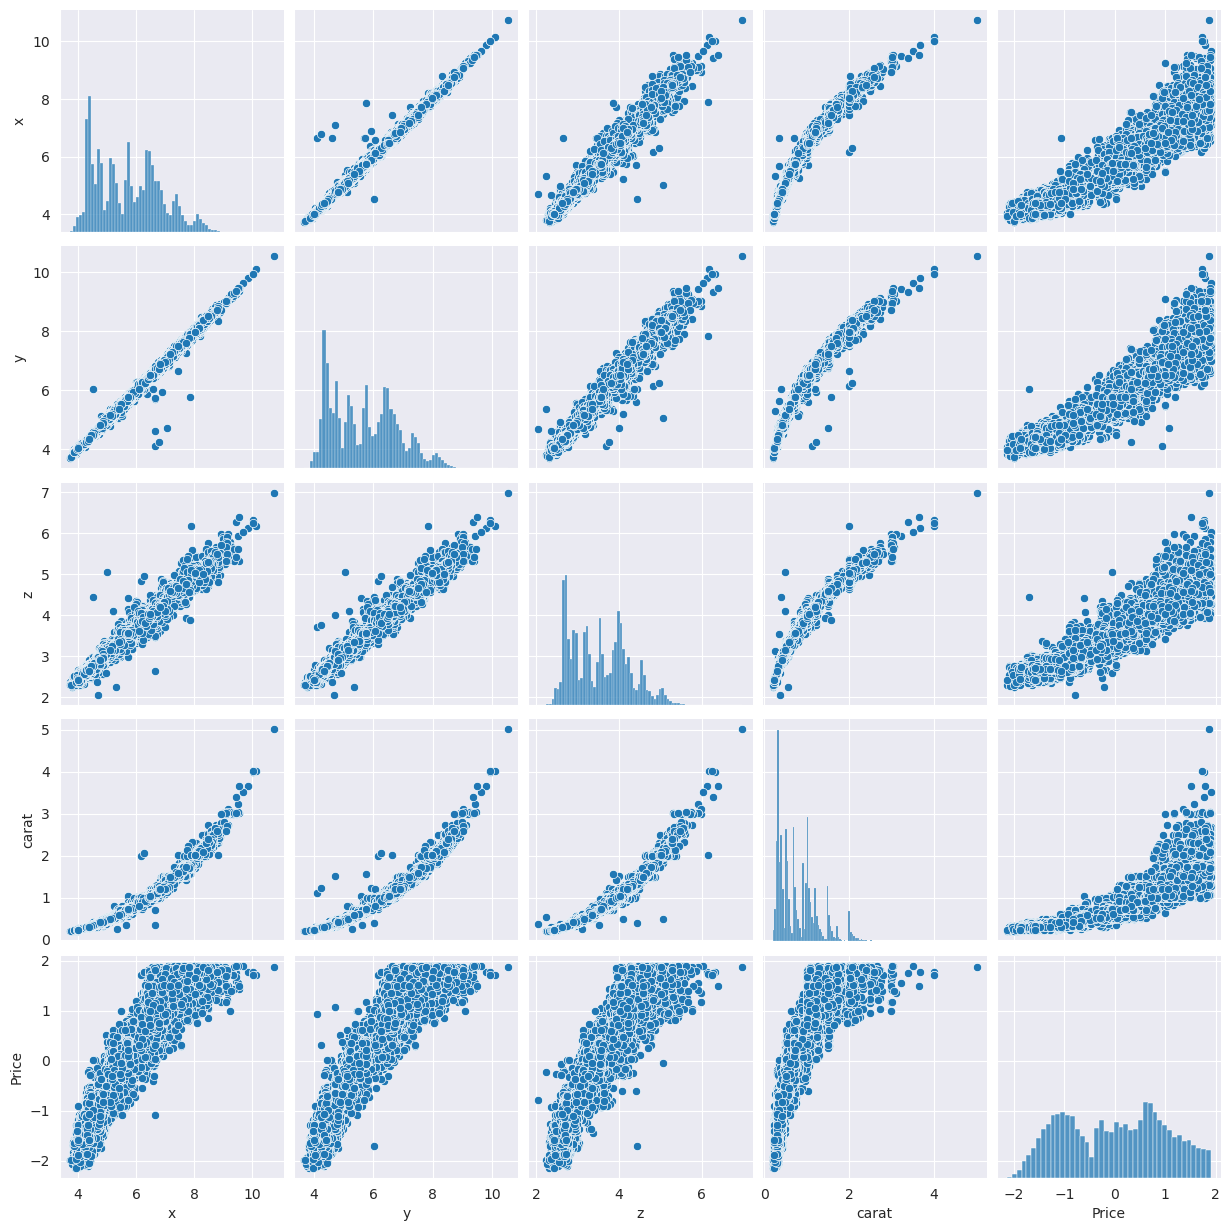

In [32]:
# Remove Outliers
diamond_train = diamond_train[diamond_train["x"]>3]
diamond_train = diamond_train[diamond_train["y"]<20]
diamond_train = diamond_train[(diamond_train["z"]>2) & (diamond_train["z"]<10)]
sns.pairplot(diamond_train[attr])

### 2.2- Viz Categorical Data with Target Column

<AxesSubplot:xlabel='cut', ylabel='Price'>

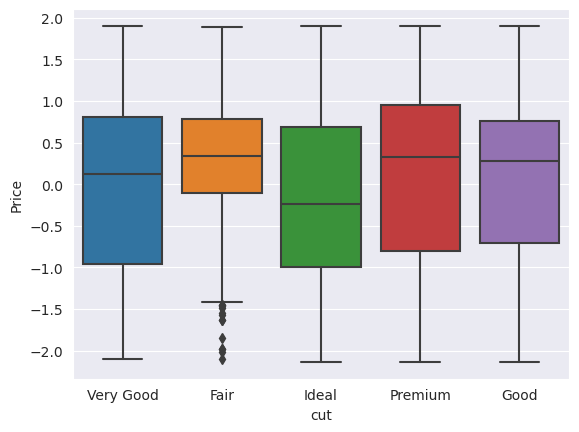

In [33]:
sns.boxplot(x= "cut" , y = "Price" , data = diamond_train)

<AxesSubplot:xlabel='color', ylabel='Price'>

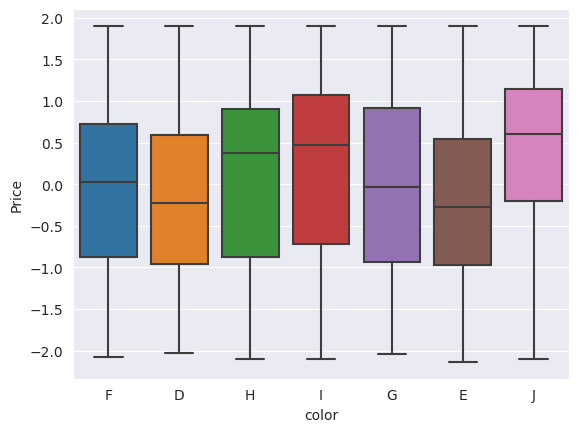

In [34]:
sns.boxplot(x= "color" , y = "Price" , data = diamond_train)

<AxesSubplot:xlabel='clarity', ylabel='Price'>

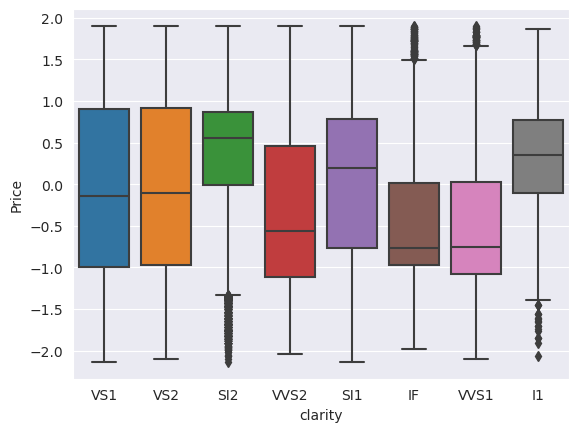

In [35]:
sns.boxplot(x= "clarity" , y = "Price" , data = diamond_train)

# Prepare Data  for ML Algorithms

In [36]:
Diamond = diamond_train.copy() 

In [37]:
Diamond_features = Diamond.drop("Price",axis = 1)

Diamond_features.head()

,carat,cut,color,clarity,depth,table,x,y,z
39054,0.38,Very Good,F,VS1,62.1,54.7,4.63,4.66,2.89
7435,0.90,Fair,F,VS2,64.4,53.0,6.08,6.04,3.90
43118,0.52,Ideal,D,SI2,62.5,56.0,5.12,5.08,3.19
7394,0.33,Premium,H,VS1,59.5,59.0,4.48,4.53,2.68
39313,0.38,Ideal,H,VVS2,61.4,57.0,4.65,4.63,2.85


In [38]:
Diamond_label = Diamond[["Price"]]
Diamond_label

,Price
39054,-0.794095
7435,0.589474
43118,-0.510352
7394,-1.459055
39313,-0.783052
...,...
11646,0.754664
33503,-1.059311
17566,1.059728
42752,-0.542403


In [39]:
Diamond_cat = Diamond_features.select_dtypes(include = "object")
Diamond_cat

,cut,color,clarity
39054,Very Good,F,VS1
7435,Fair,F,VS2
43118,Ideal,D,SI2
7394,Premium,H,VS1
39313,Ideal,H,VVS2
...,...,...,...
11646,Premium,J,VS2
33503,Ideal,F,VS2
17566,Ideal,H,VS2
42752,Ideal,G,SI2


In [40]:
Diamond_num = Diamond_features.drop(Diamond_cat, axis = 1)
Diamond_num

,carat,depth,table,x,y,z
39054,0.38,62.1,54.7,4.63,4.66,2.89
7435,0.90,64.4,53.0,6.08,6.04,3.90
43118,0.52,62.5,56.0,5.12,5.08,3.19
7394,0.33,59.5,59.0,4.48,4.53,2.68
39313,0.38,61.4,57.0,4.65,4.63,2.85
...,...,...,...,...,...,...
11646,1.20,62.6,57.0,6.80,6.72,4.23
33503,0.30,60.5,56.0,4.37,4.33,2.63
17566,1.20,61.2,59.0,6.84,6.89,4.20
42752,0.58,62.2,55.0,5.40,5.36,3.35


## Handling categorical Columns

In [41]:
Diamond_cat.head()

,cut,color,clarity
39054,Very Good,F,VS1
7435,Fair,F,VS2
43118,Ideal,D,SI2
7394,Premium,H,VS1
39313,Ideal,H,VVS2


In [42]:
Diamond_cat_1hot = Diamond_cat.drop("cut",axis = 1)
Diamond_cat_ordinal = Diamond_cat[["cut"]]

display(Diamond_cat_1hot.columns)
print("-"*60)
display(Diamond_cat_ordinal.columns)


Index(['color', 'clarity'], dtype='object')

------------------------------------------------------------


Index(['cut'], dtype='object')

## Transformation Pipelines

In [43]:
# pipeline for numerical columns
num_pipe = Pipeline([
    ("imputer" ,SimpleImputer(missing_values = 0 ,strategy = "mean")),
    ("scalar" , StandardScaler())])

In [44]:
#full transform 
full_pipe = ColumnTransformer([
              ("num",num_pipe,list(Diamond_num)),
              ("cat_1hot",OneHotEncoder(sparse = False),list(Diamond_cat_1hot)),
              ("cat_ord",OrdinalEncoder(),list(Diamond_cat_ordinal))
            ])

In [45]:
Diamond_Prepard = full_pipe.fit_transform(Diamond_features)
Diamond_Prepard.shape

(43134, 22)

# Select and Train a Model

In [46]:
def Model_Evaluation (Actual_y , Pred_y,X,Model):

    print("R^2:",r2_score(Actual_y, Pred_y))
    print("Adjusted R^2:",1 - (1-r2_score(Actual_y, Pred_y))*(len(Actual_y)-1)/(len(Actual_y)-X.shape[1]-1))
    print("MAE:",mean_absolute_error(Actual_y, Pred_y))
    print("MSE:",mean_squared_error(Actual_y, Pred_y))
    print("RMSE:",mean_squared_error(Actual_y, Pred_y,squared = False))

### 1- LinearRegression

In [47]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(Diamond_Prepard, Diamond_label)

LinearRegression()

In [48]:
y_pred = lin_reg.predict(Diamond_Prepard)
Model_Evaluation(Diamond_label,y_pred,Diamond_Prepard,lin_reg)

R^2: 0.9811125943055399
Adjusted R^2: 0.9811029558623287
MAE: 0.10650966226252312
MSE: 0.018885176606923255
RMSE: 0.13742334811422421


### 2-  DecisionTreeRegressor

In [49]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(Diamond_Prepard, Diamond_label)

DecisionTreeRegressor(random_state=42)

In [50]:
y_pred = tree_reg.predict(Diamond_Prepard)
Model_Evaluation(Diamond_label,y_pred,Diamond_Prepard,tree_reg)

R^2: 0.9999830172270645
Adjusted R^2: 0.9999830085605755
MAE: 0.00019899713110732342
MSE: 1.698076863225122e-05
RMSE: 0.004120772819781651


### 3- LGBMRegressor

In [51]:
lgbm_model = LGBMRegressor(max_depth=8, n_estimators=555, boosting_type='gbdt', random_state=42)
lgbm_model.fit(Diamond_Prepard, Diamond_label) 

LGBMRegressor(max_depth=8, n_estimators=555, random_state=42)

In [52]:
y_pred = lgbm_model.predict(Diamond_Prepard)
Model_Evaluation(Diamond_label,y_pred,Diamond_Prepard,lgbm_model)

R^2: 0.9946261093508499
Adjusted R^2: 0.994623366997523
MAE: 0.053456036048145854
MSE: 0.005373256423737379
RMSE: 0.0733024994371773


### 4- RandomForestRegressor

In [53]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(Diamond_Prepard, Diamond_label)

RandomForestRegressor(random_state=42)

In [54]:
y_pred = forest_reg.predict(Diamond_Prepard)
Model_Evaluation(Diamond_label,y_pred,Diamond_Prepard,forest_reg)

R^2: 0.9988602938611275
Adjusted R^2: 0.9988597122570113
MAE: 0.023509501187589456
MSE: 0.0011395716310003945
RMSE: 0.03375754183883054


## Better Evaluation using Cross Validation 

In [55]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [56]:
lin_scores = cross_val_score(lin_reg, Diamond_Prepard, Diamond_label,
                             cv=10)
lin_rmse_scores = lin_scores
display_scores(lin_rmse_scores)

Scores: [0.97924419 0.98096414 0.9815326  0.98240648 0.98105553 0.98034748
 0.98175477 0.98048295 0.98021676 0.98220389]
Mean: 0.9810208777365634
Standard deviation: 0.0009311472682605964


In [57]:
tree_scores = cross_val_score(tree_reg, Diamond_Prepard, Diamond_label,
                         cv=10)

tree_rmse_scores = tree_scores
display_scores(tree_rmse_scores)

Scores: [0.98349725 0.98470881 0.98447563 0.98568391 0.98536776 0.9844548
 0.98566175 0.98373749 0.98441618 0.98475789]
Mean: 0.9846761483649032
Standard deviation: 0.0007000526908060598


In [58]:
lgbm_scores = cross_val_score(lgbm_model, Diamond_Prepard, Diamond_label,
                         cv=10)

lgbm_rmse_scores = lgbm_scores
display_scores(lgbm_rmse_scores)

Scores: [0.99223168 0.99287357 0.99285081 0.99324045 0.99298299 0.99246339
 0.99309003 0.99257799 0.99262074 0.99299048]
Mean: 0.9927922125790992
Standard deviation: 0.0002954628511584842


**Linear Regrission is the best**

## Evaluate Your System on the Test Set

In [59]:
Test_Set = diamond_test.copy()
Test_Set.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
8552,1.01,Ideal,E,SI2,62.8,57.0,4434,6.38,6.35,4.00
47143,0.72,Ideal,J,SI1,62.7,56.0,1832,5.67,5.75,3.58
39988,0.41,Premium,F,VS2,61.1,56.0,1107,4.84,4.79,2.94
47767,0.55,Premium,D,VS2,61.6,56.0,1894,5.33,5.28,3.27
10770,1.13,Premium,I,SI1,61.5,60.0,4854,6.72,6.68,4.12


In [60]:
Test_Set["Price"] = np.log1p(Test_Set["price"])
Test_Set.drop("price", axis = 1)

,carat,cut,color,clarity,depth,table,x,y,z,Price
8552,1.01,Ideal,E,SI2,62.8,57.0,6.38,6.35,4.00,8.397283
47143,0.72,Ideal,J,SI1,62.7,56.0,5.67,5.75,3.58,7.513709
39988,0.41,Premium,F,VS2,61.1,56.0,4.84,4.79,2.94,7.010312
47767,0.55,Premium,D,VS2,61.6,56.0,5.33,5.28,3.27,7.546974
10770,1.13,Premium,I,SI1,61.5,60.0,6.72,6.68,4.12,8.487764
...,...,...,...,...,...,...,...,...,...,...
26505,2.02,Ideal,I,SI1,62.4,56.0,8.07,8.11,5.05,9.688374
32803,0.34,Ideal,E,VS1,62.4,55.0,4.44,4.47,2.78,6.692084
44061,0.55,Ideal,E,SI1,61.7,57.0,5.23,5.27,3.24,7.347300
1046,0.70,Ideal,F,VS2,62.3,53.0,5.69,5.73,3.56,7.975221


<AxesSubplot:xlabel='Price', ylabel='Count'>

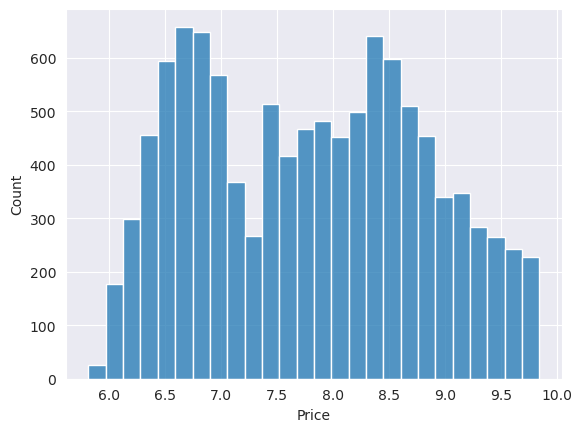

In [61]:
sns.histplot(x = "Price" , data = Test_Set)

In [62]:
X_test = Test_Set.drop("Price",axis = 1)
y_test = Test_Set[["Price"]]

In [63]:
X_test.describe()

,carat,depth,table,price,x,y,z
count,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000,10789.000000
mean,0.800394,61.726360,57.445815,3959.669849,5.738422,5.740635,3.543374
std,0.476125,1.404807,2.222212,4007.166777,1.125160,1.116508,0.747130
min,0.200000,52.200000,43.000000,334.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,952.000000,4.710000,4.720000,2.910000
50%,0.710000,61.800000,57.000000,2453.000000,5.710000,5.720000,3.530000
75%,1.040000,62.500000,59.000000,5392.000000,6.540000,6.540000,4.040000
max,4.500000,71.000000,73.000000,18806.000000,10.230000,10.160000,31.800000


In [64]:
X_test_prepard = full_pipe.transform(X_test)

In [65]:
X_test_prepard.shape

(10789, 22)

In [66]:
y_test_pred = lin_reg.predict(X_test_prepard)

In [67]:
Model_Evaluation(y_test,y_test_pred,X_test_prepard,lin_reg)

R^2: -57.67573898299992
Adjusted R^2: -57.795641106130695
MAE: 7.789529088282759
MSE: 60.71488586796432
RMSE: 7.791975735842888
